In [1]:
import pickle

import os 
import glob
import random
import pickle
from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter
import plyfile
import numpy as np
import open3d as o3d
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_distances
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import open3d as o3d
from sklearn.decomposition import PCA
from scipy.spatial import distance
from sklearn.metrics.pairwise import euclidean_distances

import cv2
import numpy as np

import os.path as osp
import sys
ws_dir = '/local/home/ekoller/BT'
print(ws_dir)
sys.path.append(ws_dir)
from utils import evaluation, scan3r


data_dir ='/local/home/ekoller/R3Scan'
scenes_dir = '/local/home/ekoller/R3Scan/scenes'
#scan_id= "38770c95-86d7-27b8-8717-3485b411ddc7" #is reference scan  since it is a reference scan everything shouls be correctly hit
curr_scan_id =  "02b33e01-be2b-2d54-93fb-4145a709cec5"#"02b33e01-be2b-2d54-93fb-4145a709cec5" 
new_scan_id =  "fcf66d88-622d-291c-871f-699b2d063630" #"fcf66d8a-622d-291c-8429-0e1109c6bb26"
frame_number = "000007"
curr_frame_number = "000007"
new_frame_number = "000008"
patch_h= 18
image_height = 540
image_width = 960
patch_w = 32
patch_height = 30
patch_width = 30

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
/local/home/ekoller/BT


In [2]:
def visualize(mask, new_ids, title):
    plt.figure(figsize=(12, 6))

    # Display the mask
    plt.subplot(1, 2, 1)
    plt.imshow(mask, cmap='gray')
    plt.title('Mask')
    plt.axis('off')

    # Display the new_ids array
    plt.subplot(1, 2, 2)
    plt.imshow(new_ids, cmap='gray')
    plt.title(title)
    plt.axis('off')

    plt.show()

#visualitation of the following: with the new ids fill in an image with the new ids
#compute the resulting image when comparing stuff

def generate_pairs_pixel_level( dino_data,id_matches):
    
    new_ids = np.zeros((image_height, image_width))


    #go over every mask and fill in the id into the new_ids which it got mapped to
    for seg_region in dino_data:
        mask_id = seg_region["object_id"]
        #print("mask id ", mask_id)
        #get to what the region mapped in the embeddings
        matched_id = id_matches[mask_id]
        #print("matched id ", matched_id)
        mask = seg_region["mask"]
        boolean_mask = mask == 225
        new_ids[boolean_mask] = matched_id[0] #[0] is the id the second one is the error
        #visualize(boolean_mask, new_ids, f'Updated new_ids with mask id {mask_id}')

    #returns the new ids on a pixel wise level
    return new_ids


In [3]:
#this codesegment takes an image on a pixel wise level and quantizes it such that every patch has only the id of the most often occuring id
def quantize_to_patch_level(pixelwise_img):
    #get the shape of the pixelwise img
    input_h, input_w = pixelwise_img.shape
    patch_width = int(input_w/patch_w)
    patch_height= int(input_h/patch_h)

    patchwise_w = patch_w #number of patches
    patchwise_h = patch_h

    patchwise_id = np.zeros((patchwise_h,patchwise_w))

    for i in range(patchwise_h):
            for j in range(patchwise_w):
                # Define the coordinates of the current patch
                h_start = i * patch_height
                w_start = j * patch_width
                h_end = h_start + patch_height
                w_end = w_start + patch_width
                
                # Get the current patch from the input matrix
                patch = pixelwise_img[h_start:h_end, w_start:w_end]
                
                # get the most reoccuring id of the patch
                flattened_patch = patch.flatten()
                # Find the most common value in the patch
                value_counts = Counter(flattened_patch)
                most_common_id = value_counts.most_common(1)[0][0]
                
                # Assign the most common ID to the new matrix
                patchwise_id[i, j] = most_common_id


    return patchwise_id


In [4]:
#for a given scene get the colours of the differnt object_ids
def get_id_colours(data_dir,scan_id):
    #access the mesh file to get the colour of the ids
    mesh_file = osp.join(data_dir,"scenes", scan_id, "labels.instances.annotated.v2.ply")
    ply_data = plyfile.PlyData.read(mesh_file)
    # Extract vertex data
    vertices = ply_data['vertex']
    vertex_count = len(vertices)
    
    # Initialize dictionary to store object_id -> color mappings
    object_colors = {}
    
   # Iterate through vertices
    for i in range(vertex_count):
        vertex = vertices[i]
        object_id = vertex['objectId']
        color = (vertex['red'], vertex['green'], vertex['blue'])
        
        # Check if object_id already in dictionary, otherwise initialize a Counter
        if object_id in object_colors:
            object_colors[object_id][color] += 1
        else:
            object_colors[object_id] = Counter({color: 1})
    
    # Convert Counter to dictionary with most frequent color
    for object_id, color_counter in object_colors.items():
        most_common_color = color_counter.most_common(1)[0][0]
        object_colors[object_id] = np.array(most_common_color[::-1])
    
    return object_colors

colors = get_id_colours(data_dir,curr_scan_id)
print("cur scan id colors", colors.keys())
colors = get_id_colours(data_dir,new_scan_id)
print("new scan id colors", colors.keys())


cur scan id colors dict_keys([4, 18, 2, 0, 3, 1, 100, 16, 8, 9, 24, 25, 29, 6, 26, 10, 11, 23, 27, 22, 5, 20, 12, 15, 13, 14, 103, 21])
new scan id colors dict_keys([4, 9, 24, 1, 8, 22, 23, 12, 10, 0, 27])


In [5]:
#this function creates a color image of the size 960x540 from the patches
def create_color_img_from_obj_id(data_dir,scan_id,obj_id_mat):
    #access the mesh file to get the colour of the ids
    colour_dict = get_id_colours(data_dir, scan_id)
    #initialize the new matrix 
    og_height, og_width = obj_id_mat.shape
    new_height = og_height * patch_height
    new_width = og_width * patch_width

    colour_mat = np.zeros((new_height,new_width,3))

    #go over each element and assign the colour of the dictionary
    for h in range(og_height):
        for w in range(og_width):
            if obj_id_mat[h][w] in colour_dict.keys():
                colour = colour_dict[obj_id_mat[h][w]]
                colour_mat[h*patch_height:(h+1)*patch_height, w*patch_width:(w+1)*patch_width] = colour


    return colour_mat


    

In [6]:
#given a gt patchwise matrix and a newly calculated matrix compute the accuracy
#aaparently this is not the same as accuracy
#given a gt patchwise matrix and a newly calculated matrix compute the accuracy
def get_accuracy(gt_patches, computed_patches):
    #make sure we dont do something dumm lol
    assert gt_patches.shape == computed_patches.shape, "Matrices must have the same shape"

    # Flatten matrices to iterate over each element
    flat_gt = gt_patches.flatten()
    flat_comp = computed_patches.flatten()

    percentage = np.zeros_like(flat_gt)
    
    total_instances = len(flat_gt)
    correct_instances = 0

    #compute based on the other way
    for idx in range(len(percentage)):
        if flat_gt[idx] == flat_comp[idx]:
            percentage[idx] = 1
    
    # Count correct instances where IDs match
    for id_gt, id_comp in zip(flat_gt, flat_comp):
        if id_gt == id_comp:
            correct_instances += 1
            
    
    # Compute accuracy
    accuracy = correct_instances / total_instances
    
    return accuracy, np.mean(percentage)

In [7]:

def avg_pooling(all_features_curr_scene):
    #get every fearure vector and average the patches to one patch
    all_features = []
    all_colors = []
    all_ids = []
    for frame in all_features_curr_scene:
        for obj_id in all_features_curr_scene[frame]:
            if obj_id != 0:
                matrix = all_features_curr_scene[frame][obj_id]
                #averaging
                aggregated_feature = np.mean(matrix, axis=0)  
                all_features.append(aggregated_feature)
                all_ids.append(obj_id)
                #all_colors.append(tuple(c / 255.0 for c in colors[obj_id]))

    return all_features, all_ids,all_colors

def max_pooling(all_features_curr_scene):
    #perform max pooling 
    all_features = []
    all_colors = []
    all_ids = []
    for frame in all_features_curr_scene:
        for obj_id in all_features_curr_scene[frame]:
            if obj_id != 0:
                matrix = all_features_curr_scene[frame][obj_id]

                #max pooling
                aggregated_feature = np.max(matrix, axis=0)  # Max pooling across patches
                all_features.append(aggregated_feature)
                all_ids.append(obj_id)
                # append color corresponding to the object id
                #all_colors.append(tuple(c / 255.0 for c in colors[obj_id]))

    return all_features, all_ids, all_colors


def display_images(gt_image, new_image, title1, title2):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(gt_image)
    plt.title(title1)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(new_image)
    plt.title(title2)
    plt.axis('off')

    plt.show()

given an input image which was segmented using dino, use PCA & either average or maxpooling to compute the accuracy of the predicted object id

In [9]:

"""
for the current scene: access all the precomputed dinov2 features and do pca of the space
"""
print(new_scan_id)
#get all the features of the current scene
all_info_path = osp.join(data_dir,"files/Features2D/projection/DinoV2/patch_32_18", curr_scan_id + ".pkl")
with open(all_info_path, 'rb') as file:
    all_features_curr_scene = pickle.load(file)

#using avg pooling
all_features, all_ids, all_colors = avg_pooling(all_features_curr_scene)
all_features = np.array(all_features)
all_ids = np.array(all_ids)
all_colors = np.array(all_colors)

#perform pca to 3D reduction
pca = PCA(n_components=3)
reduced_points = pca.fit_transform(all_features)


"""
access the features of the new scene and the info corresponding to the patches
"""

#get the Dinov2 features for the input image ( the segmented one)
input_featues_path = osp.join(data_dir,"files/Features2D/dino_segmentation/DinoV2/patch_32_18", new_scan_id + ".pkl")
with open(input_featues_path, 'rb') as file:
    input_features = pickle.load(file)

#get the data information on the segmentation of the input image
input_info_path = osp.join(data_dir,"files/Segmentation/DinoV2/objects", new_scan_id + ".pkl")
with open(input_info_path, 'rb') as file:
    input_info = pickle.load(file)



total_accuracy= []

"""
decide the id matches based on the projected points and 5 neighbouhood vote
"""

#iterate over each frame of the newscan and perform the assignment 
for frame in input_features:
    #initialze the matches
    id_matches= {}

    input_dict = input_features[frame]

    #iterate through every patch of the segmented new scene image, project it into the pca space ang get the closest
    for img_id, img_vec in input_dict.items():
        #reshape and project into the space

        #use avg pooling
        aggregated_vec = np.mean(img_vec, axis=0)
        #print("new vec shape", aggregated_vec.shape)
        reduced_unseen_point = pca.transform(aggregated_vec.reshape(1,-1))

        # cosine distances to all reduced points
        #distances = cosine_distances(reduced_unseen_point, reduced_points)

        #eucledian dist
        distances = euclidean_distances(reduced_unseen_point, reduced_points)

        #get closest 5 points
        num_neighbors = 1
        closest_indices = np.argsort(distances[0])[:num_neighbors]
        closest_distances = distances[0][closest_indices]

        # classs of 5 closest points
        closest_classes = all_ids[closest_indices]

        # get the majority class and write into id_matches
        most_common_class, count = Counter(closest_classes).most_common(1)[0]
        id_matches[img_id] = (most_common_class, closest_distances)


    print("id mateches", id_matches)


    """
    turn the best match id into a pixelwise level, then patchwise level
    """

    #assign each pixel to the new value, curr_scan_id , frame number is only for the size
    new_img_pixelwise = generate_pairs_pixel_level(input_info[frame], id_matches)

    #quantize to patches
    new_img_patchwise = quantize_to_patch_level(new_img_pixelwise)
    #aggregate to patches and colour it, we want the colours which are used in curr_scan id
    new_img_colour = create_color_img_from_obj_id(data_dir,curr_scan_id, new_img_patchwise)
    print("unique numbers in new img patchwise ", np.unique(new_img_patchwise))


    """
    access the gt of the image and get the accuracy of the prediction, print result and display 
    """
    #get the gt patches for the segmented scene! so for the dinov2 segmentation: but the colour will be based on the current scene
    gt_input_patchwise_path =  osp.join(data_dir,"files/patch_anno/patch_anno_32_18", new_scan_id + '.pkl')
    with open(gt_input_patchwise_path, 'rb') as file:
        gt_input_patchwise = pickle.load(file)
    #print("unique numbers in gt_input_colour ", np.unique(gt_input_patchwise[frame]))
    gt_input_colour = create_color_img_from_obj_id(data_dir,curr_scan_id,gt_input_patchwise[frame])


    accuracy = get_accuracy(gt_input_patchwise[frame],new_img_patchwise)
    total_accuracy.append(accuracy[0])
    print("the accuracy for the current features of the sam boundingboxes vs the gt boundingboxes is", accuracy)


    # """
    # display the newly computed images next to each other
    # """

    #display the gt_image and the new patchwise image next to each other
    title1 = "gt_patces"
    title2 = "dino_seg_patches"

    # Swap color channels from RGB to BGR (if needed)
    gt_input_colour_bgr = gt_input_colour[..., ::-1]  # Convert RGB to BGR
    new_img_colour_bgr = new_img_colour[..., ::-1]    # Convert RGB to BGR

    # Create a blank canvas to combine images horizontally
    height = max(gt_input_colour.shape[0], new_img_colour.shape[0])  # Max height of both images
    width = gt_input_colour.shape[1] + new_img_colour.shape[1] + 20  # Total width of both images with a small gap
    combined_image = np.zeros((height, width, 3), dtype=np.uint8)

    # Place images with titles on the blank canvas
    combined_image[:gt_input_colour.shape[0], :gt_input_colour.shape[1]] = gt_input_colour
    combined_image[:new_img_colour.shape[0], gt_input_colour.shape[1] + 20:] = new_img_colour

    # Add titles to the images
    cv2.putText(combined_image, title1, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
    cv2.putText(combined_image, title2, (gt_input_colour.shape[1] + 30, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

    # Display the combined image
    cv2.imshow('Two Images Side by Side', combined_image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

np_accuracy = np.array(total_accuracy)
mean = np.mean(np_accuracy)
print("mean of total accuracy ", mean)




fcf66d88-622d-291c-871f-699b2d063630
id mateches {1: (23, array([0.01570257], dtype=float32)), 2: (12, array([0.01312101], dtype=float32)), 3: (1, array([0.02636981], dtype=float32)), 4: (5, array([0.00739935], dtype=float32)), 5: (9, array([0.01593802], dtype=float32)), 6: (8, array([0.01633052], dtype=float32)), 7: (18, array([0.02055096], dtype=float32)), 8: (9, array([0.00719532], dtype=float32)), 9: (11, array([0.01523954], dtype=float32)), 10: (10, array([0.00754297], dtype=float32)), 11: (5, array([0.01760643], dtype=float32))}
unique numbers in new img patchwise  [ 1.  5.  8.  9. 10. 11. 12. 18. 23.]
the accuracy for the current features of the sam boundingboxes vs the gt boundingboxes is (0.3663194444444444, 0.3663194444444444)
id mateches {1: (23, array([0.02890891], dtype=float32)), 2: (27, array([0.01526292], dtype=float32)), 3: (27, array([0.00507543], dtype=float32)), 4: (22, array([0.0243516], dtype=float32)), 5: (8, array([0.01412289], dtype=float32)), 6: (1, array([0.0

here we use maxpooling insteat of avg pooling

id mateches {1: (8, 0), 2: (13, 0), 3: (1, 0), 4: (10, 0), 5: (27, 0), 6: (2, 0), 7: (18, 0), 8: (10, 0), 9: (27, 0), 10: (11, 0), 11: (5, 0)}
unique numbers in new img patchwise  [ 1.  2.  5.  8. 10. 11. 13. 18. 27.]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


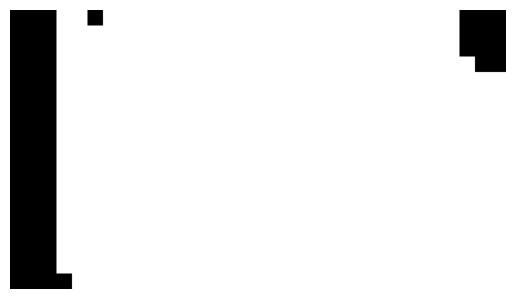

the accuracy for the current features of the sam boundingboxes vs the gt boundingboxes is (0.2638888888888889, 0.2638888888888889)
id mateches {1: (21, 0), 2: (26, 0), 3: (26, 0), 4: (9, 0), 5: (27, 0), 6: (1, 0), 7: (5, 0), 8: (10, 0), 9: (8, 0), 10: (23, 0), 11: (12, 0)}
unique numbers in new img patchwise  [ 1.  5.  8.  9. 10. 12. 21. 23. 26. 27.]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


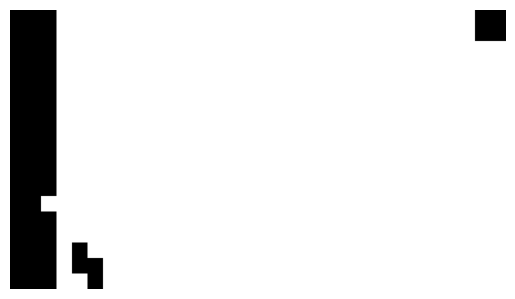

the accuracy for the current features of the sam boundingboxes vs the gt boundingboxes is (0.4913194444444444, 0.4913194444444444)
id mateches {1: (25, 0), 2: (25, 0), 3: (23, 0), 4: (11, 0), 5: (27, 0), 6: (1, 0), 7: (16, 0), 8: (29, 0), 9: (27, 0), 10: (22, 0), 11: (22, 0), 12: (8, 0), 13: (20, 0), 14: (9, 0), 15: (8, 0)}
unique numbers in new img patchwise  [ 1.  8.  9. 11. 16. 20. 22. 23. 25. 27. 29.]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


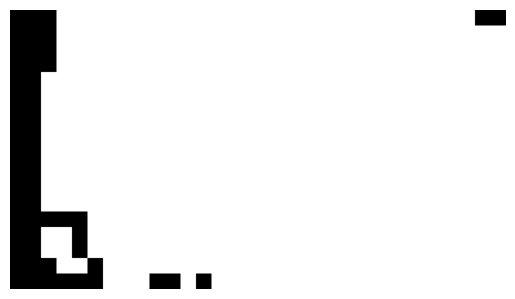

the accuracy for the current features of the sam boundingboxes vs the gt boundingboxes is (0.515625, 0.515625)
id mateches {1: (22, 0), 2: (11, 0), 3: (27, 0), 4: (1, 0), 5: (1, 0), 6: (8, 0), 7: (23, 0)}
unique numbers in new img patchwise  [ 1.  8. 11. 22. 23. 27.]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


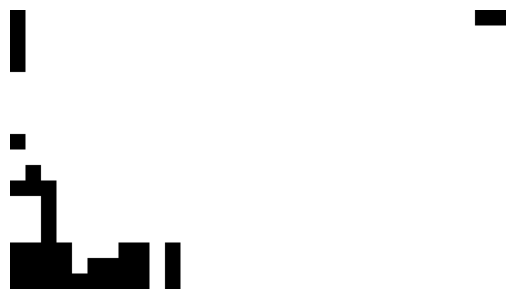

the accuracy for the current features of the sam boundingboxes vs the gt boundingboxes is (0.6041666666666666, 0.6041666666666666)
id mateches {1: (9, 0), 2: (26, 0), 3: (27, 0), 4: (1, 0), 5: (8, 0), 6: (2, 0), 7: (15, 0)}
unique numbers in new img patchwise  [ 1.  2.  8.  9. 15. 26. 27.]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


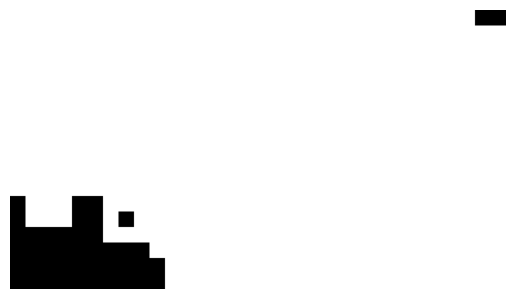

the accuracy for the current features of the sam boundingboxes vs the gt boundingboxes is (0.5486111111111112, 0.5486111111111112)
id mateches {1: (26, 0), 2: (27, 0), 3: (1, 0), 4: (22, 0)}
unique numbers in new img patchwise  [ 1. 22. 26. 27.]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


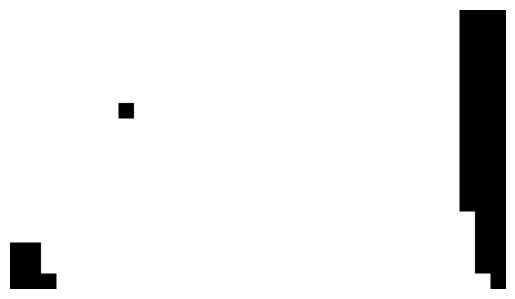

the accuracy for the current features of the sam boundingboxes vs the gt boundingboxes is (0.5590277777777778, 0.5590277777777778)
id mateches {1: (9, 0), 2: (27, 0), 3: (25, 0), 4: (20, 0), 5: (24, 0), 6: (26, 0)}
unique numbers in new img patchwise  [ 9. 20. 24. 25. 26. 27.]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


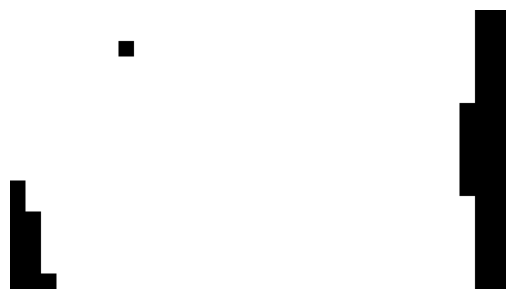

the accuracy for the current features of the sam boundingboxes vs the gt boundingboxes is (0.0, 0.0)
id mateches {1: (11, 0), 2: (22, 0), 3: (11, 0), 4: (3, 0), 5: (9, 0), 6: (24, 0), 7: (24, 0), 8: (8, 0)}
unique numbers in new img patchwise  [ 3.  8.  9. 11. 22. 24.]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


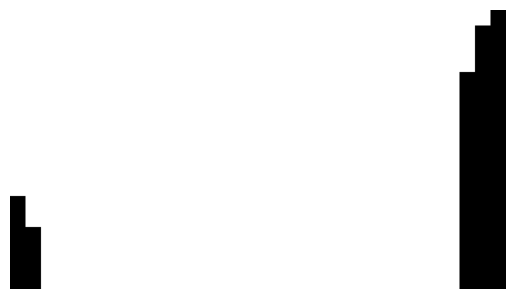

the accuracy for the current features of the sam boundingboxes vs the gt boundingboxes is (0.003472222222222222, 0.003472222222222222)
id mateches {1: (23, 0), 2: (26, 0), 3: (25, 0), 4: (8, 0), 5: (24, 0), 6: (20, 0), 7: (6, 0), 8: (22, 0), 9: (2, 0), 10: (10, 0), 11: (8, 0)}
unique numbers in new img patchwise  [ 2.  6.  8. 10. 20. 22. 23. 24. 25. 26.]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


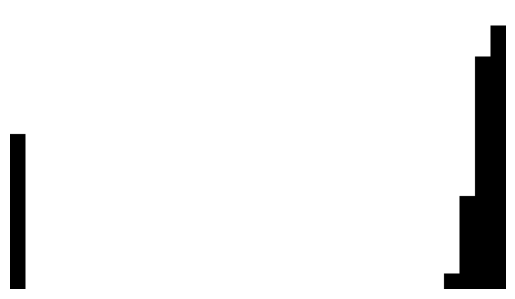

the accuracy for the current features of the sam boundingboxes vs the gt boundingboxes is (0.001736111111111111, 0.001736111111111111)
id mateches {1: (8, 0), 2: (12, 0), 3: (25, 0), 4: (24, 0), 5: (8, 0), 6: (27, 0), 7: (1, 0), 8: (25, 0), 9: (27, 0), 10: (2, 0)}
unique numbers in new img patchwise  [ 1.  2.  8. 12. 24. 25. 27.]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


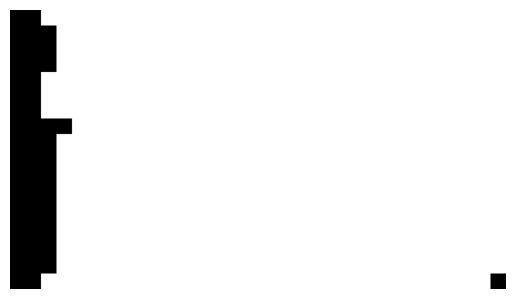

the accuracy for the current features of the sam boundingboxes vs the gt boundingboxes is (0.6232638888888888, 0.6232638888888888)
id mateches {1: (12, 0), 2: (25, 0), 3: (25, 0), 4: (20, 0), 5: (27, 0), 6: (5, 0), 7: (23, 0), 8: (29, 0), 9: (1, 0), 10: (26, 0), 11: (2, 0)}
unique numbers in new img patchwise  [ 1.  2.  5. 12. 20. 23. 25. 26. 27. 29.]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


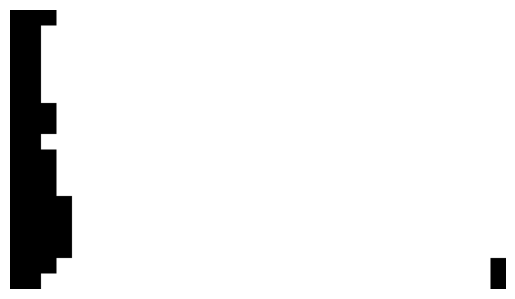

the accuracy for the current features of the sam boundingboxes vs the gt boundingboxes is (0.019097222222222224, 0.019097222222222224)
id mateches {1: (1, 0), 2: (8, 0)}
unique numbers in new img patchwise  [1. 8.]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


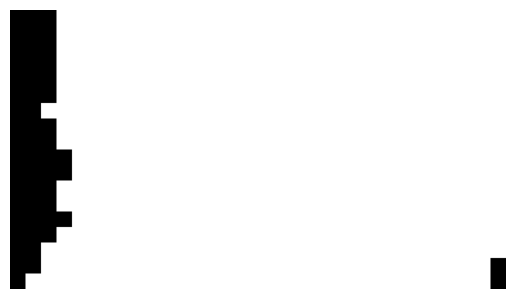

the accuracy for the current features of the sam boundingboxes vs the gt boundingboxes is (0.6145833333333334, 0.6145833333333334)
id mateches {1: (5, 0), 2: (22, 0), 3: (20, 0), 4: (100, 0), 5: (9, 0), 6: (23, 0), 7: (3, 0), 8: (25, 0)}
unique numbers in new img patchwise  [  3.   5.   9.  20.  22.  23.  25. 100.]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


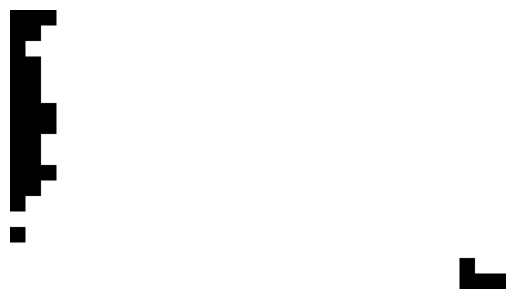

the accuracy for the current features of the sam boundingboxes vs the gt boundingboxes is (0.0, 0.0)
mean of total accuracy  0.32652243589743585


In [8]:

"""
for the current scene: access all the precomputed dinov2 features and do pca of the space
"""
#get all the features of the current scene
all_info_path = osp.join(data_dir,"files/Features2D/projection/DinoV2/patch_32_18", curr_scan_id + ".pkl")
with open(all_info_path, 'rb') as file:
    all_features_curr_scene = pickle.load(file)

#using avg pooling
all_features, all_ids, all_colors = max_pooling(all_features_curr_scene)
all_features = np.array(all_features)
all_ids = np.array(all_ids)
all_colors = np.array(all_colors)

#perform pca to 3D reduction
pca = PCA(n_components=3)
reduced_points = pca.fit_transform(all_features)


"""
access the features of the new scene and the info corresponding to the patches
"""

#get the Dinov2 features for the input image ( the segmented one)
input_featues_path = osp.join(data_dir,"files/Features2D/dino_segmentation/DinoV2/patch_32_18", new_scan_id + ".pkl")
with open(input_featues_path, 'rb') as file:
    input_features = pickle.load(file)

#get the data information on the segmentation of the input image
input_info_path = osp.join(data_dir,"files/Segmentation/DinoV2/objects", new_scan_id + ".pkl")
with open(input_info_path, 'rb') as file:
    input_info = pickle.load(file)



total_accuracy= []

"""
decide the id matches based on the projected points and 5 neighbouhood vote
"""

#iterate over each frame of the newscan and perform the assignment 
for frame in input_features:
    #initialze the matches
    id_matches= {}

    input_dict = input_features[frame]

    #iterate through every patch of the segmented new scene image, project it into the pca space ang get the closest
    for img_id, img_vec in input_dict.items():
        #reshape and project into the space

        #use avg pooling
        aggregated_vec = np.max(img_vec, axis=0)
        #print("new vec shape", aggregated_vec.shape)
        reduced_unseen_point = pca.transform(aggregated_vec.reshape(1,-1))

        # cosine distances to all reduced points
        #distances = cosine_distances(reduced_unseen_point, reduced_points)

        #eucledian dist
        distances = euclidean_distances(reduced_unseen_point, reduced_points)

        #get closest 5 points
        num_neighbors = 5
        closest_indices = np.argsort(distances[0])[:num_neighbors]

        # classs of 5 closest points
        closest_classes = all_ids[closest_indices]

        # get the majority class and write into id_matches
        most_common_class, count = Counter(closest_classes).most_common(1)[0]
        id_matches[img_id] = (most_common_class, 0)


    print("id mateches", id_matches)


    """
    turn the best match id into a pixelwise level, then patchwise level
    """

    #assign each pixel to the new value, curr_scan_id , frame number is only for the size
    new_img_pixelwise = generate_pairs_pixel_level(input_info[frame], id_matches)

    #quantize to patches
    new_img_patchwise = quantize_to_patch_level(new_img_pixelwise)
    #aggregate to patches and colour it, we want the colours which are used in curr_scan id
    new_img_colour = create_color_img_from_obj_id(data_dir,curr_scan_id, new_img_patchwise)
    print("unique numbers in new img patchwise ", np.unique(new_img_patchwise))


    """
    access the gt of the image and get the accuracy of the prediction, print result and display 
    """
    #get the gt patches for the segmented scene! so for the dinov2 segmentation: but the colour will be based on the current scene
    gt_input_patchwise_path =  osp.join(data_dir,"files/patch_anno/patch_anno_32_18", new_scan_id + '.pkl')
    with open(gt_input_patchwise_path, 'rb') as file:
        gt_input_patchwise = pickle.load(file)
    #print("unique numbers in gt_input_colour ", np.unique(gt_input_patchwise[frame]))
    gt_input_colour = create_color_img_from_obj_id(data_dir,curr_scan_id,gt_input_patchwise[frame])
    plt.imshow(gt_input_colour)
    plt.axis('off')  # Optional: turn off axis
    plt.show()


    accuracy = get_accuracy(gt_input_patchwise[frame],new_img_patchwise)
    total_accuracy.append(accuracy[0])
    print("the accuracy for the current features of the sam boundingboxes vs the gt boundingboxes is", accuracy)


    # """
    # display the newly computed images next to each other
    # """

    # #display the gt_image and the new patchwise image next to each other
    # title1 = "gt_patces"
    # title2 = "dino_seg_patches"

    # # Create a blank canvas to combine images horizontally
    # height = max(gt_input_colour.shape[0], new_img_colour.shape[0])  # Max height of both images
    # width = gt_input_colour.shape[1] + new_img_colour.shape[1] + 20  # Total width of both images with a small gap
    # combined_image = np.zeros((height, width, 3), dtype=np.uint8)

    # # Place images with titles on the blank canvas
    # combined_image[:gt_input_colour.shape[0], :gt_input_colour.shape[1]] = gt_input_colour
    # combined_image[:new_img_colour.shape[0], gt_input_colour.shape[1] + 20:] = new_img_colour

    # # Add titles to the images
    # cv2.putText(combined_image, title1, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
    # cv2.putText(combined_image, title2, (gt_input_colour.shape[1] + 30, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

    # # Display the combined image
    # cv2.imshow('Two Images Side by Side', combined_image)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()

np_accuracy = np.array(total_accuracy)
mean = np.mean(np_accuracy)
print("mean of total accuracy ", mean)